## Potential Flows

Suppose we want to estimate the optimal transport map from $P$ to $Q$ using iid samples $\{X_i\}_{i=1}^n \sim P$ and $\{Y_i\}_{i=1}^n \sim Q$. The dual objective is given by
$$\min_{f \in CVX(P)} \sum_i f(X_i) + f^*(Y_i).$$

#### Some notation

1. Let $p: \mathbb{R} \to \mathbb{R}$ denote the rational quadratic spline. Consequently, $x \mapsto p(x; \theta)$ is scalar to scalar non-linear monotonic function.
2. Let $\phi: \mathbb{R} \to \mathbb{R}$ denote the integral of the RQ spline. Consequently, $x \mapsto \phi(x; \theta) = \int_{-B}^x p(y; \theta) dy$ is scalar to scalar convex function.
3. Let $T^A_{i}: \mathbb{R}^d \to \mathbb{R}^d$ be an affine map given by $x \mapsto A_iX + b_i$ with positive elements in $A_i$. The parameters of this map are $\theta_i := (A_i, b_i)$.
4. Let $T^S_{j}: \mathbb{R}^d \to \mathbb{R}^d$ be a map given by $x \mapsto [p(x_1; \theta_j^1), \dots, p(x_d; \theta_j^d)]$. The parameters of this map are the spline parameters of $d$ splines denoted by $\theta_j := (\theta_j^1, \dots, \theta_j^d)$.
5. Finally, $\Phi: \mathbb{R}^d \to \mathbb{R}$ is an input convex function given by sum of $d$ spline integrals $x \mapsto \sum_{k=1}^d \phi(x_k; \theta^k)$. The parameters of this map are the spline parameters of $d$ splines denoted by $\theta := (\theta^1, \dots, \theta^d)$.

Let 
$$T = T_k^A \circ T_{k-1}^S \circ \dots \circ T_2^S \circ T_1^A$$
be a composition of affine and RQ spline based componentwise non-linear trasnport layers. This composition is a non-linear monotonic function. Finally, we parameterize $f$ as 
$$f_\theta(x) = \Phi(T(x))$$
where $\theta = (\theta^1, \dots, \theta^d, A_k, b_k, \theta_{k-1}, \dots, \theta_2, A_1, b_1)$ are the parameters of transports $T_1, \dots, T_k$ and of the final input convex function $\Phi$. Since convex function composed with monotonic function is a convex function of the inputs, $f_\theta$ is an input-convex function parameterization.

Unlike previously, $\nabla f_\theta$ is not a diagonal map unless $T$ is an identity function because
$$\nabla_x f_\theta (x) = \nabla f_{\theta}(T(x))\,\, J T(x).$$

Note that 
$$\nabla f_{\theta}(y) = [p(y_1; \theta^1), \dots, p(y_d; \theta^d)]$$
and 
$$JT(x) = JT_{k}(S_{k-1}(x)) \,\, J T_{k-1}(S_{k-2}(X)) \cdots JT_1(x)$$
where $S_j(x) = T_j \circ \cdots T_1(x)$.
For an affine monotonic layer $J T^A_j(x) = A_j$ and $J T^S_j(x) = \text{diag}(p'(x_1; \theta_j^1), \dots, p'(x_d; \theta_j^d))$.

In order to minimize the dual objective, we need $\nabla_\theta f_\theta(x)$ and $\nabla_\theta f_\theta^*(y)$. The former is available via autodiff. For latter, we know that
$$f_\theta^*(y) = \langle y, (\nabla f_\theta)^{-1}(y)\rangle - f_\theta (\nabla f_\theta)^{-1}(y)).$$

However $\nabla (f_\theta)^{-1}(y)$ is not available in closed form and we need to calculate it numerically by solving the following problem
$$(\nabla f_\theta)^{-1}(y) = \argmax_{x}  \left(\langle x, y \rangle - f_\theta (x)\right).$$

Let the numerical solution to above problem be $x^*_\theta$, then the optimality condition gives
$$\nabla_\theta f_\theta^*(y) \approx -\nabla_\theta f_{\theta}(x^*_\theta).$$

Now with access to $\nabla_\theta f_{\theta}$ and $\nabla_\theta f^*_{\theta}$, we can do gradient descent on the dual objective.

In [19]:
import sys
sys.path.append("../../")
from potential_flows import transforms
from potential_flows import potential
import torch
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

#### Creating source and target data

In [43]:
n = 1000
d = 2
x1 = torch.randn(n,1)
x2 = x1.pow(2) + torch.randn(n,1)
from_data = torch.cat([x1,x2], dim=-1)
to_data = torch.randn(n,d)

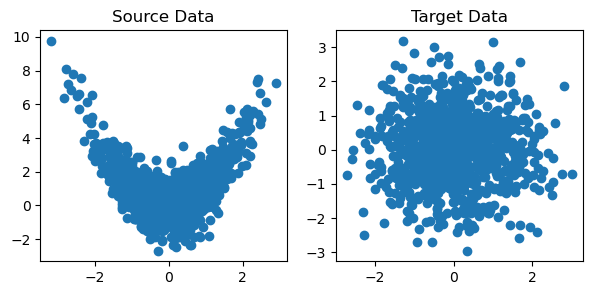

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(x1,x2)
axs[0].set_title("Source Data")
axs[1].scatter(to_data[:,0], to_data[:,1])
axs[1].set_title("Target Data")
plt.show()

#### Creating the flow

In [22]:
layer_identity = transforms.IdentityTransform()
layer_affine1 = transforms.PositiveLinear(d)
layer_spline1 = transforms.RQspline(data_shape=(d,), num_bins=4)
layer_affine2 = transforms.PositiveLinear(d)
layer_spline2 = transforms.RQspline(data_shape=(d,), num_bins=4)
layers = transforms.CompositeTransform([layer_affine1, layer_spline1, layer_affine2, layer_spline2])
potential_flow = potential.ICRQ(layers, (d,))
potential_flow.to("cuda")

ICRQ(
  (Tmap): CompositeTransform(
    (_transforms): ModuleList(
      (0): IdentityTransform()
      (1): CompositeTransform(
        (_transforms): ModuleList(
          (0): PositiveLinear()
          (1): RQspline()
          (2): PositiveLinear()
          (3): RQspline()
        )
      )
    )
  )
)

#### Plotting $T$ and $\nabla_X f$
which are both monotonic $\mathbb{R}^d \to \mathbb{R}^d$ functions

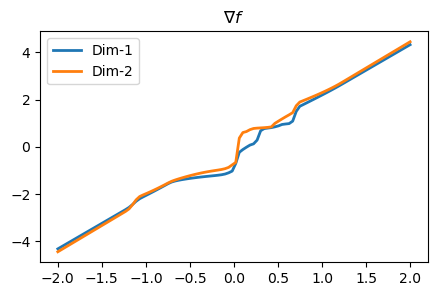

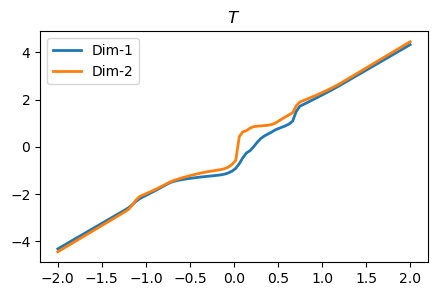

In [23]:

potential_flow.plot_flow(100)
potential_flow.plot_Tmap(100)

#### Calculating $(\nabla_x f_\theta)^{-1}(Y_i)$

We need to calculate $(\nabla_x f_\theta)^{-1}(Y_i)$ for all $i \in \{1, \dots, n\}$. However solving the problem
$$X_{\theta i}^* =: \nabla (f_\theta)^{-1}(Y_i) = \argmax_{x} \langle Y_i, X\rangle - f_\theta(Y_i)$$
in a loop for all $i$ is not feasible computationally. So we define the objective function `objective_function` that returns 
$$ - \sum_i \langle Y_i, X\rangle - f_\theta(Y_i)$$
to be minimized for calculating approximate $n \times d$ tensor $[(\nabla f)^{-1}(Y_1), \dots, (\nabla f)^{-1}(Y_n)]$.

In [24]:
def objective_function(x, y, potential_flow):
    '''
    y: n * d
    x: n * d
    potential_flow: potential function
    '''
    return -torch.sum(torch.sum(x*y, dim=-1) - potential_flow.integral(x))

def approx_inv_flow(potential_flow, y, inner_iter=100):
    x0 = torch.ones(y.shape).to("cuda")
    x0.requires_grad = True
    optimizer = torch.optim.Adam([x0], lr=.001)
    potential_flow.requires_grad_(False)
    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        loss = objective_function(x0, y, potential_flow)
        loss.backward()  # Compute gradients
        return loss
    for i in tqdm(range(inner_iter)):
        optimizer.step(closure)
    optimized_parameters = x0.detach()
    return optimized_parameters



In [41]:
# def objective_function2(x, y, potential_flow):
#     return -torch.sum(x*y, dim=-1) - potential_flow.integral(x)

# def approx_inv_flow2(potential_flow, y, inner_iter=100, tolerance=1e-4):
#     n = y.shape[0]
#     x0 = torch.ones(y.shape).to("cuda")
#     x0.requires_grad = True
#     potential_flow.requires_grad_(False)
#     optimizer = torch.optim.Adam([x0], lr=.001)

#     for i in tqdm(range(inner_iter)):
#         prev_x0 = x0.clone().detach()
#         j = torch.randint(0, n, (1,))
#         optimizer.zero_grad()
#         loss = objective_function2(x0[j], y[j], potential_flow)
#         loss.backward()  # Compute gradients
#         optimizer.step()
        
#         if torch.norm(x0 - prev_x0) < tolerance:
#             print("Converged")
#             break
#         if i%100 == 0:
#             print(f'Step {i}, Component {j}: Objective = {loss.item()}')

#     optimized_parameters = x0.detach()
#     return optimized_parameters

In [ ]:
# x_star = approx_inv_flow2(potential_flow, torch.ones(n,d, requires_grad=True).to("cuda"), 10*n)

#### Plotting the `objective_function` vs $X$ for a fixed $Y$

In [38]:
def dummy(x, y, potential_flow):
    return torch.sum(x*y, dim=-1) - potential_flow.integral(x)
y_test = torch.zeros(n,d).to("cuda")
x_test = torch.linspace(-50,50, n).to("cuda")
z_test = torch.zeros(n,n).to("cuda")
for i in tqdm(range(n)):
    with torch.no_grad():
        foo = torch.cat([x_test[i]*torch.ones(n,1).to("cuda"), x_test.unsqueeze(-1)], dim=1)
        z_test[i,:] = dummy(foo, y_test, potential_flow)


100%|██████████| 1000/1000 [00:13<00:00, 75.99it/s]


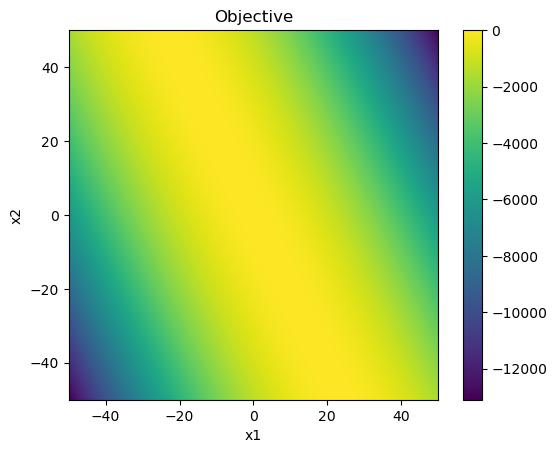

In [39]:
z_test = z_test.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
plt.imshow(z_test, extent=[x_test.min(), x_test.max(), x_test.min(), x_test.max()], origin='lower', cmap='viridis')

# Add a colorbar
plt.colorbar()

# Add labels and a title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Objective')

# Show the plot
plt.show()

In [45]:
def calculate_loss_gradients(potential_flow, x, y):
    n = x.shape[0]
    with torch.no_grad():
        x_star = approx_inv_flow(potential_flow, y)
        loss = torch.mean(potential_flow.integral(x) + torch.sum(y*x_star, dim=-1) - potential_flow.integral(x_star))
        # print(torch.isnan(x_star).any().item(), torch.mean(potential_flow.integral(x_star)))
    potential_flow.requires_grad_(True)
    grad = torch.sum(potential_flow.integral(x))/n
    grad_conjugate = torch.sum(potential_flow.integral(x_star))/n

    model_gradient = torch.autograd.grad(grad, potential_flow.parameters())
    model_star_gradient = torch.autograd.grad(grad_conjugate, potential_flow.parameters())

    return loss, tuple(a - b for a, b in zip(model_gradient, model_star_gradient))

In [46]:
max_iter = 100
learning_rate = 1e-4
losses = []
for epoch in tqdm(range(max_iter)):
    potential_flow.zero_grad()
    loss, loss_gradient = calculate_loss_gradients(potential_flow, from_data.to("cuda"), to_data.to("cuda"))
    print(f'Loss: {loss}')
    losses.append(loss)
    
    # Update model parameters
    with torch.no_grad():
        
        for param, grad in zip(potential_flow.parameters(), loss_gradient):
            param -= learning_rate * grad
    torch.cuda.empty_cache()

  1%|          | 1/100 [00:02<04:50,  2.94s/it]

Loss: 6.449361324310303


  2%|▏         | 2/100 [00:05<04:50,  2.96s/it]

Loss: 6.441909313201904


  3%|▎         | 3/100 [00:08<04:48,  2.98s/it]

Loss: 6.434471130371094


  4%|▍         | 4/100 [00:11<04:44,  2.96s/it]

Loss: 6.427045822143555


  5%|▌         | 5/100 [00:14<04:40,  2.96s/it]

Loss: 6.419638633728027


  6%|▌         | 6/100 [00:17<04:36,  2.94s/it]

Loss: 6.4122419357299805


  7%|▋         | 7/100 [00:20<04:35,  2.96s/it]

Loss: 6.404862880706787


  8%|▊         | 8/100 [00:23<04:33,  2.97s/it]

Loss: 6.397497177124023


  9%|▉         | 9/100 [00:26<04:31,  2.98s/it]

Loss: 6.3901448249816895


 10%|█         | 10/100 [00:29<04:29,  2.99s/it]

Loss: 6.382807731628418


 11%|█         | 11/100 [00:32<04:24,  2.97s/it]

Loss: 6.37548303604126


 12%|█▏        | 12/100 [00:35<04:21,  2.97s/it]

Loss: 6.368173599243164


 13%|█▎        | 13/100 [00:38<04:16,  2.95s/it]

Loss: 6.360879421234131


 14%|█▍        | 14/100 [00:41<04:16,  2.98s/it]

Loss: 6.3535966873168945


 15%|█▌        | 15/100 [00:44<04:14,  2.99s/it]

Loss: 6.3463311195373535


 16%|█▌        | 16/100 [00:47<04:08,  2.96s/it]

Loss: 6.339078903198242


 17%|█▋        | 17/100 [00:50<04:05,  2.96s/it]

Loss: 6.331840991973877


 18%|█▊        | 18/100 [00:53<04:03,  2.97s/it]

Loss: 6.324617385864258


 19%|█▉        | 19/100 [00:56<04:01,  2.98s/it]

Loss: 6.31740665435791


 20%|██        | 20/100 [00:59<03:57,  2.97s/it]

Loss: 6.310210227966309


 21%|██        | 21/100 [01:02<03:54,  2.97s/it]

Loss: 6.303029537200928


 22%|██▏       | 22/100 [01:05<03:53,  2.99s/it]

Loss: 6.295860767364502


 23%|██▎       | 23/100 [01:08<03:49,  2.98s/it]

Loss: 6.288706302642822


 24%|██▍       | 24/100 [01:11<03:46,  2.98s/it]

Loss: 6.281565189361572


 25%|██▌       | 25/100 [01:14<03:42,  2.96s/it]

Loss: 6.274441719055176


 26%|██▌       | 26/100 [01:17<03:39,  2.97s/it]

Loss: 6.267327308654785


 27%|██▋       | 27/100 [01:20<03:36,  2.96s/it]

Loss: 6.260229110717773


 28%|██▊       | 28/100 [01:23<03:33,  2.96s/it]

Loss: 6.253146648406982


 29%|██▉       | 29/100 [01:26<03:30,  2.96s/it]

Loss: nan


 30%|███       | 30/100 [01:28<03:26,  2.94s/it]

Loss: nan


 31%|███       | 31/100 [01:31<03:20,  2.91s/it]

Loss: nan


 32%|███▏      | 32/100 [01:34<03:18,  2.92s/it]

Loss: nan


 33%|███▎      | 33/100 [01:37<03:15,  2.92s/it]

Loss: nan


 34%|███▍      | 34/100 [01:40<03:11,  2.91s/it]

Loss: nan


 35%|███▌      | 35/100 [01:43<03:09,  2.91s/it]

Loss: nan


 36%|███▌      | 36/100 [01:46<03:05,  2.91s/it]

Loss: nan


 37%|███▋      | 37/100 [01:49<03:02,  2.89s/it]

Loss: nan


 38%|███▊      | 38/100 [01:52<02:59,  2.90s/it]

Loss: nan


 39%|███▉      | 39/100 [01:54<02:55,  2.88s/it]

Loss: nan


 40%|████      | 40/100 [01:57<02:52,  2.87s/it]

Loss: nan


 41%|████      | 41/100 [02:00<02:49,  2.88s/it]

Loss: nan


 42%|████▏     | 42/100 [02:03<02:46,  2.87s/it]

Loss: nan


 43%|████▎     | 43/100 [02:06<02:44,  2.89s/it]

Loss: nan


 44%|████▍     | 44/100 [02:09<02:41,  2.88s/it]

Loss: nan


 45%|████▌     | 45/100 [02:12<02:38,  2.88s/it]

Loss: nan


 46%|████▌     | 46/100 [02:15<02:35,  2.89s/it]

Loss: nan


 47%|████▋     | 47/100 [02:18<02:33,  2.90s/it]

Loss: nan


 48%|████▊     | 48/100 [02:20<02:29,  2.88s/it]

Loss: nan


 49%|████▉     | 49/100 [02:23<02:25,  2.86s/it]

Loss: nan


 50%|█████     | 50/100 [02:26<02:23,  2.86s/it]

Loss: nan


 51%|█████     | 51/100 [02:29<02:20,  2.86s/it]

Loss: nan


 52%|█████▏    | 52/100 [02:32<02:16,  2.85s/it]

Loss: nan


 53%|█████▎    | 53/100 [02:35<02:15,  2.89s/it]

Loss: nan


 54%|█████▍    | 54/100 [02:38<02:12,  2.89s/it]

Loss: nan


 55%|█████▌    | 55/100 [02:40<02:09,  2.87s/it]

Loss: nan


 56%|█████▌    | 56/100 [02:43<02:06,  2.88s/it]

Loss: nan


 57%|█████▋    | 57/100 [02:46<02:02,  2.86s/it]

Loss: nan


 58%|█████▊    | 58/100 [02:49<01:59,  2.85s/it]

Loss: nan


 59%|█████▉    | 59/100 [02:52<01:56,  2.85s/it]

Loss: nan


 60%|██████    | 60/100 [02:55<01:54,  2.85s/it]

Loss: nan


 61%|██████    | 61/100 [02:58<01:51,  2.86s/it]

Loss: nan


 62%|██████▏   | 62/100 [03:01<01:49,  2.88s/it]

Loss: nan


 63%|██████▎   | 63/100 [03:03<01:46,  2.87s/it]

Loss: nan


 64%|██████▍   | 64/100 [03:06<01:43,  2.88s/it]

Loss: nan


 65%|██████▌   | 65/100 [03:09<01:40,  2.87s/it]

Loss: nan


 66%|██████▌   | 66/100 [03:12<01:37,  2.87s/it]

Loss: nan


 67%|██████▋   | 67/100 [03:15<01:34,  2.87s/it]

Loss: nan


 68%|██████▊   | 68/100 [03:18<01:32,  2.88s/it]

Loss: nan


 69%|██████▉   | 69/100 [03:21<01:29,  2.88s/it]

Loss: nan


 70%|███████   | 70/100 [03:23<01:26,  2.87s/it]

Loss: nan


 71%|███████   | 71/100 [03:26<01:22,  2.84s/it]

Loss: nan


 72%|███████▏  | 72/100 [03:29<01:19,  2.84s/it]

Loss: nan


 73%|███████▎  | 73/100 [03:32<01:17,  2.86s/it]

Loss: nan


 74%|███████▍  | 74/100 [03:35<01:14,  2.88s/it]

Loss: nan


 75%|███████▌  | 75/100 [03:38<01:11,  2.88s/it]

Loss: nan


 76%|███████▌  | 76/100 [03:41<01:08,  2.87s/it]

Loss: nan


 77%|███████▋  | 77/100 [03:44<01:06,  2.87s/it]

Loss: nan


 78%|███████▊  | 78/100 [03:46<01:03,  2.87s/it]

Loss: nan


 79%|███████▉  | 79/100 [03:49<01:00,  2.89s/it]

Loss: nan


 80%|████████  | 80/100 [03:52<00:57,  2.88s/it]

Loss: nan


 81%|████████  | 81/100 [03:55<00:55,  2.91s/it]

Loss: nan


 82%|████████▏ | 82/100 [03:58<00:52,  2.90s/it]

Loss: nan


 83%|████████▎ | 83/100 [04:01<00:49,  2.89s/it]

Loss: nan


 84%|████████▍ | 84/100 [04:04<00:46,  2.90s/it]

Loss: nan


 85%|████████▌ | 85/100 [04:07<00:43,  2.90s/it]

Loss: nan


 86%|████████▌ | 86/100 [04:10<00:40,  2.88s/it]

Loss: nan


 87%|████████▋ | 87/100 [04:12<00:37,  2.89s/it]

Loss: nan


 88%|████████▊ | 88/100 [04:15<00:34,  2.89s/it]

Loss: nan


 89%|████████▉ | 89/100 [04:18<00:31,  2.90s/it]

Loss: nan


 90%|█████████ | 90/100 [04:21<00:28,  2.87s/it]

Loss: nan


 91%|█████████ | 91/100 [04:24<00:25,  2.88s/it]

Loss: nan


 92%|█████████▏| 92/100 [04:27<00:23,  2.88s/it]

Loss: nan


 93%|█████████▎| 93/100 [04:30<00:20,  2.87s/it]

Loss: nan


 94%|█████████▍| 94/100 [04:33<00:17,  2.88s/it]

Loss: nan


 95%|█████████▌| 95/100 [04:35<00:14,  2.87s/it]

Loss: nan


 96%|█████████▌| 96/100 [04:38<00:11,  2.87s/it]

Loss: nan


 97%|█████████▋| 97/100 [04:41<00:08,  2.88s/it]

Loss: nan


 98%|█████████▊| 98/100 [04:44<00:05,  2.88s/it]

Loss: nan


 99%|█████████▉| 99/100 [04:47<00:02,  2.87s/it]

Loss: nan


100%|██████████| 100/100 [04:50<00:00,  2.90s/it]

Loss: nan


In [ ]:
model_path = "potential_flow.pth"
torch.save(potential_flow.state_dict(), model_path)


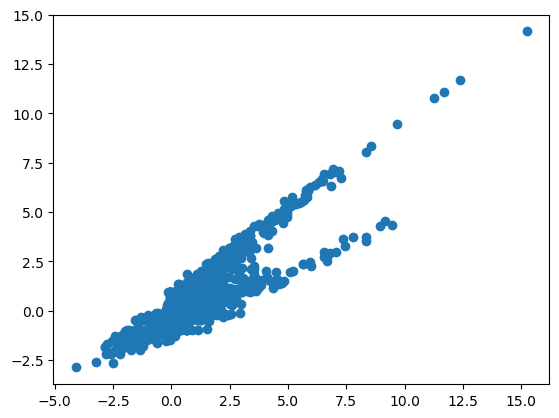

In [ ]:
normalized_data = potential_flow.gradient(from_data).detach()
plt.scatter(normalized_data[:,0], normalized_data[:,1])

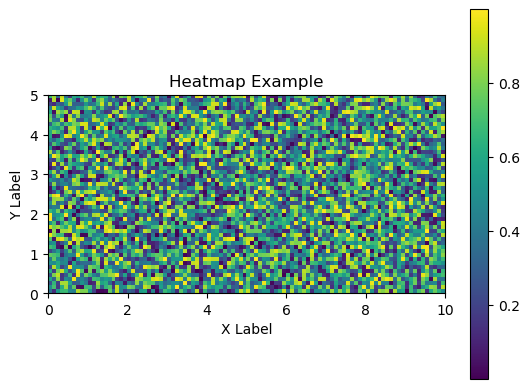

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your x, y, and z components)
x = np.linspace(0, 10, 100)  # Replace with your x values
y = np.linspace(0, 5, 50)    # Replace with your y values
z = np.random.rand(len(y), len(x))  # Replace with your z values

# Create a heatmap using imshow
plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis')

# Add a colorbar
plt.colorbar()

# Add labels and a title
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.title('Heatmap Example')

# Show the plot
plt.show()


In [ ]:
def RQ_bin_integral(x_k, x, y_k, w_k, h_k, der_k, der_k_plus_one, N=1000, eps=1e-5):
    device = x_k.device
    s_k = h_k/w_k
    tau_k = der_k + der_k_plus_one - 2 * s_k # shape: 1 * d
    x_minus_x_k = x - x_k
    bin_integral = y_k*x_minus_x_k
    line = torch.linspace(0,1-eps,N).to(device)
    mc = torch.cat([line]*np.prod(x_k.shape)).reshape(*x_k.shape, N)*(x_minus_x_k/w_k).unsqueeze(-1).to(device)
    mc_num = (s_k - der_k).unsqueeze(-1)*mc.pow(2) + der_k.unsqueeze(-1)*mc
    mc_denom = -tau_k.unsqueeze(-1)*mc.pow(2) + tau_k.unsqueeze(-1)*mc + s_k.unsqueeze(-1)
    bin_integral += h_k*x_minus_x_k*torch.sum(mc_num/mc_denom, dim=-1)/N
    return bin_integral


In [ ]:
def integral(self, inputs, context=None):
    assert inputs.device == self.device()
    inputs = self.Tmap(inputs)
    inside_interval_mask = (inputs > -self.tail_bound) & (inputs < self.tail_bound)
    outputs = torch.zeros_like(inputs)
    inputs_cpy = torch.clone(inputs)
    inputs_cpy[~inside_interval_mask] = 0
    self.bin_checks()

    lesser_than_B_mask = inputs <= -self.tail_bound
    greater_than_B_mask = inputs >= self.tail_bound
    inputs_cpy[lesser_than_B_mask], inputs_cpy[greater_than_B_mask] = -self.tail_bound+1e-5, self.tail_bound - 1e-5
    widths, cumwidths, heights, cumheights, derivatives, deltas = self.normalized_all_parameters()
    bin_idx = transforms.searchsorted(cumwidths, inputs_cpy)[..., None]
    # print(f'Bin index: {bin_idx}, shape: {bin_idx.shape}')
    if ((bin_idx < 0) | (bin_idx > self.num_bins-1)).any():
        raise transforms.InputOutsideDomain()
    input_cumwidths, input_bin_widths, input_cumheights, input_bin_heights, input_deltas, input_derivatives, input_derivatives_plus_one = gather_inputs(bin_idx, widths, cumwidths, heights, cumheights, derivatives, deltas)


    bin_integrals = RQ_bin_integral(cumwidths[...,:-1], cumwidths[...,1:], cumheights[...,:-1], widths, heights, 
                                    derivatives[...,:-1], derivatives[...,1:])

    cum_bin_integrals = torch.cumsum(bin_integrals, dim=-1) # shape: 1 * d * K
    cum_bin_integrals = F.pad(cum_bin_integrals[None,...], pad=(1,0), mode='constant', value=0.0) # shape: 1 * d * K+1
    outputs = torch.cat([cum_bin_integrals.clone()]*bin_idx.shape[0], dim=0).gather(-1, bin_idx)[..., 0] 
    outputs += RQ_bin_integral(input_cumwidths, inputs, input_cumheights, input_bin_widths, input_bin_heights, 
                                input_derivatives, input_derivatives_plus_one)

    outputs[lesser_than_B_mask] = (inputs[lesser_than_B_mask].pow(2) - 4*(self.tail_bound**2))/2
    outputs[inside_interval_mask] -= (3*(self.tail_bound**2))/2
    outputs[greater_than_B_mask] = (torch.cat([cum_bin_integrals] * bin_idx.shape[0], dim=0)[..., -1])[greater_than_B_mask]
    outputs[greater_than_B_mask] += (inputs[greater_than_B_mask].pow(2) - 4*(self.tail_bound**2))/2


    return torch.sum(outputs.view(inputs.shape[0],-1), dim=-1)


In [ ]:
from cProfile import Profile
from pstats import SortKey, Stats

In [ ]:
torch.sum(F.softplus(potential_flow.widths), dim=-1).unsqueeze(-1).shape

torch.Size([2, 1])

In [ ]:
n, d = 5, 2
x = torch.randn(n,d).to("cuda")
y = torch.randn(n,d).to("cuda")


In [ ]:
with Profile() as profile:
    print(f"{approx_inv_flow(potential_flow, y) = }")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

100%|██████████| 1000/1000 [00:27<00:00, 36.18it/s]

approx_inv_flow(potential_flow, y) = tensor([[ 0.6689, -0.2747],
        [-1.1591,  0.8226],
        [-0.4669,  0.4201],
        [-1.1253,  0.7721],
        [-1.1489,  0.7826]], device='cuda:0')
         471166 function calls (463160 primitive calls) in 27.664 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    25000    0.831    0.000    0.831    0.000 {built-in method torch.cat}
    22000    0.638    0.000    0.638    0.000 {method 'gather' of 'torch._C._TensorBase' objects}
    18000    0.135    0.000    0.135    0.000 {method 'unsqueeze' of 'torch._C._TensorBase' objects}
    17000    0.433    0.000    0.433    0.000 {built-in method torch._C._nn.softplus}
    17000    0.035    0.000    0.035    0.000 module.py:1601(__getattr__)
    15538    0.003    0.000    0.003    0.000 {built-in method builtins.len}
    14000    0.555    0.000    0.555    0.000 {built-in method torch.sum}
    12715    0.007    0.000    0.009    0.000 u